# WM811k EDA

In [1]:
# Import Libaries
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
%matplotlib inline
# plt.style.use('ggplot')
from matplotlib import colors
from matplotlib import gridspec
from matplotlib.ticker import StrMethodFormatter
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
path2 = '/Users/ezinn/Desktop/LSWMD.pkl'
df = pd.read_pickle(path2)

### Simple EDA for WM811k

In [3]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [4]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [5]:
df = df.rename(columns={'trianTestLabel': 'TrainTestLabel'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   TrainTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [18]:
# convert Series to Python strings
df.TrainTestLabel = df.TrainTestLabel.astype(str)
df.failureType = df.failureType.astype(str)

### Generate numeric labels for the data

In [16]:
d_lables = {'[]': 0,
            "[['none']]": 1,
            "[['Edge-Ring']]": 2,
            "[['Edge-Loc']]": 3,
            "[['Center']]": 4,
            "[['Loc']]": 5,
            "[['Scratch']]": 6,
            "[['Random']]": 7,
            "[['Donut']]": 8,
            "[['Near-full']]": 9}

In [19]:
df['encoding'] = df.failureType.map(d_lables)

## Create new DF w/ only labeled data

In [20]:
df1 = df[df['encoding'] != 0].copy()

In [21]:
df1.failureType.value_counts()

[['none']]         147431
[['Edge-Ring']]      9680
[['Edge-Loc']]       5189
[['Center']]         4294
[['Loc']]            3593
[['Scratch']]        1193
[['Random']]          866
[['Donut']]           555
[['Near-full']]       149
Name: failureType, dtype: int64

In [22]:
f'{(1-df1.shape[0]/df.shape[0])*100:.1f} %'

'78.7 %'

In [23]:
df1.shape[0]

172950

In [24]:
df1.shape[0]-df1.failureType.value_counts()[0]

25519

In [25]:
n_labeled = df.shape[0]-638507
n_failures = n_labeled - 147431
print(f'{n_failures/n_labeled*100:.03}% failures\n  Failures:\t\t{n_failures:,}\n  Total:\t\t{n_labeled:,}')

14.8% failures
  Failures:		25,519
  Total:		172,950


### Clean up data and dimensions of Wafermap as columns

In [26]:
df1['x_'] = df1.waferMap.apply(lambda x: x.shape[0])
df1['y_'] = df1.waferMap.apply(lambda x: x.shape[1])

In [27]:
df1['shape'] = df1.waferMap.apply(lambda x: x.shape)

In [28]:
df1.failureType = df1.failureType.str.replace("'",'').str.replace("[",'').str.replace("]",'')

In [29]:
labels = df1.failureType.value_counts().index.tolist()

In [30]:
z = [np.eye(9)[i] for i in range(9)]
map_ohe = dict(zip(range(9),z))
df1['labels'] = df1.failureType.apply(lambda x: labels.index(x)).map(map_ohe)

### Setup train/dev/test split

In [31]:
df1.drop(columns='TrainTestLabel', inplace=True)

In [32]:
from sklearn.model_selection import train_test_split

X = df1[df1.columns[[0,1,2,3,-4,-3,-2]]]
y = df1[df1.columns[[-6]]]

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.3)

X_dev, X_test, y_dev, y_test = train_test_split(X_val, y_val,
                                                    stratify=y_val, 
                                                    test_size=0.5)

df1['dataset'] = ''
df1.at[X_train.index, 'dataset'] = 'train'
df1.at[X_dev.index, 'dataset'] = 'dev'
df1.at[X_test.index, 'dataset'] = 'test'

In [33]:
df1.reset_index(drop=True)

,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
...,...,...,...,...,...,...,...,...,...,...,...
172945,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Edge-Loc,3,26,30,"(26, 30)","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
172946,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Edge-Loc,3,26,30,"(26, 30)","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
172947,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Edge-Ring,2,26,30,"(26, 30)","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test
172948,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Edge-Loc,3,26,30,"(26, 30)","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train


In [34]:
df1.columns[[0,1,2,3,-4,-3,-2]]

Index(['waferMap', 'dieSize', 'lotName', 'waferIndex', 'y_', 'shape',
       'labels'],
      dtype='object')

In [35]:
df1.columns[[-6,-5,-1]]

Index(['encoding', 'x_', 'dataset'], dtype='object')

In [36]:
df1[df1.dataset == 'test'].failureType.value_counts(normalize=True)

none         0.852446
Edge-Ring    0.055969
Edge-Loc     0.030027
Center       0.024824
Loc          0.020776
Scratch      0.006900
Random       0.005011
Donut        0.003199
Near-full    0.000848
Name: failureType, dtype: float64

In [37]:
df1[df1.dataset == 'train'].failureType.value_counts(normalize=True)

none         0.852451
Edge-Ring    0.055970
Edge-Loc     0.030000
Center       0.024830
Loc          0.020774
Scratch      0.006897
Random       0.005006
Donut        0.003213
Near-full    0.000859
Name: failureType, dtype: float64

In [38]:
df1[df1.dataset == 'dev'].failureType.value_counts(normalize=True)

none         0.852440
Edge-Ring    0.055971
Edge-Loc     0.029990
Center       0.024825
Loc          0.020777
Scratch      0.006900
Random       0.005011
Donut        0.003199
Near-full    0.000887
Name: failureType, dtype: float64

In [39]:
## write to pickle protocol 5 
# df1.reset_index(drop=True).to_pickle('WM-clean.pkl')

In [40]:
df1.encoding.value_counts()

1    147431
2      9680
3      5189
4      4294
5      3593
6      1193
7       866
8       555
9       149
Name: encoding, dtype: int64

### EDA figures

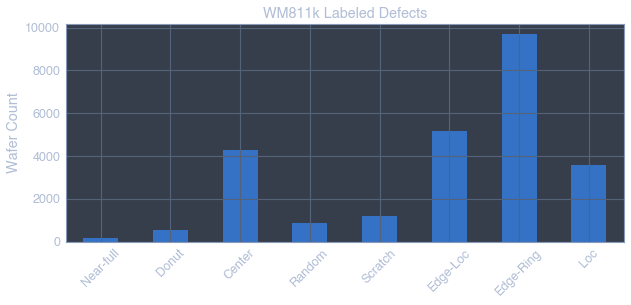

In [41]:
ax = df1[df1.failureType != 'none'].failureType.value_counts(sort=False). \
    plot(kind='bar', 
         ylabel='Wafer Count', 
         figsize = (10,4), 
         title='WM811k Labeled Defects',
        )
ax.tick_params(axis='x',rotation = 45)

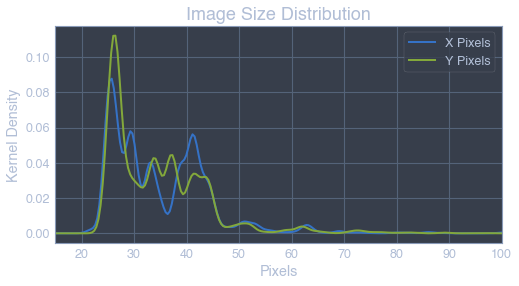

In [42]:
ax = df1[['x_','y_']]. \
    plot(kind = 'kde',
        xlim = (15,100),
        figsize = (8, 4),
        linewidth = 2,
        )
ax.set_xlabel('Pixels')
ax.set_ylabel('Kernel Density')
ax.set_title("Image Size Distribution", fontsize = 18)
ax.legend(['X Pixels', 'Y Pixels'],
#         loc = 'center left',
#         bbox_to_anchor = (1.0, 0.5)
        );

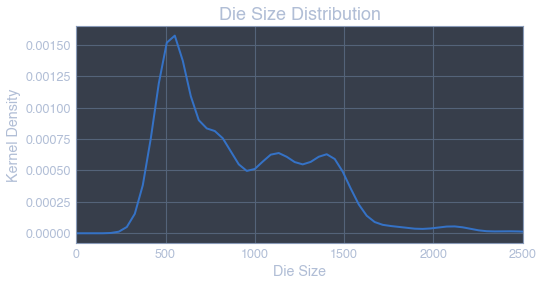

In [43]:
ax = df1.dieSize.plot(kind='kde',xlim=[0,2500],linewidth = 2, figsize=(8,4))
ax.set_ylabel('Kernel Density')
ax.set_title("Die Size Distribution", fontsize = 18)
ax.set_xlabel('Die Size');

#### Random EDA looking at image dimensions and distribution of the data

In [44]:
df1.x_.value_counts().head()

25    22955
41    17323
26    16037
29    14656
33    14352
Name: x_, dtype: int64

In [45]:
df1.y_.value_counts().head()

26    30301
27    21790
37    14402
34    13975
25    10689
Name: y_, dtype: int64

In [46]:
df1.waferMap.apply(lambda x: x.shape).value_counts().cumsum().head(30)

(25, 27)     18781
(26, 26)     33147
(30, 34)     45547
(29, 26)     57298
(27, 25)     67980
(39, 37)     78153
(33, 29)     86278
(42, 44)     93002
(44, 41)     99136
(41, 33)    104227
(35, 31)    108558
(25, 26)    112732
(41, 38)    116884
(33, 37)    120613
(29, 27)    123485
(45, 42)    126133
(43, 44)    128711
(41, 40)    131283
(41, 45)    133596
(38, 36)    135723
(38, 38)    137809
(33, 35)    139604
(51, 30)    141130
(53, 52)    142649
(26, 30)    144162
(41, 42)    145668
(41, 41)    147131
(63, 62)    148555
(34, 31)    149938
(43, 42)    151205
Name: waferMap, dtype: int64

In [47]:
df1.groupby('lotName').count().groupby('waferMap').count()

,dieSize,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset
waferMap,,,,,,,,,
1,2441,2441,2441,2441,2441,2441,2441,2441,2441
2,519,519,519,519,519,519,519,519,519
3,234,234,234,234,234,234,234,234,234
4,150,150,150,150,150,150,150,150,150
5,111,111,111,111,111,111,111,111,111
6,105,105,105,105,105,105,105,105,105
7,70,70,70,70,70,70,70,70,70
8,60,60,60,60,60,60,60,60,60
9,47,47,47,47,47,47,47,47,47


In [48]:
df1.dieSize.describe()

count    172950.000000
mean       1042.232374
std        1032.572449
min           3.000000
25%         533.000000
50%         776.000000
75%        1250.000000
max       22372.000000
Name: dieSize, dtype: float64